# Dorothea

There are two ways of describing the city of Dorothea: you can say that four aluminum towers rise from its walls flanking seven gates with spring-operated drawbridges that span the moat whose water feeds four green canals which cross the city, dividing it into nine quarters, each with three hundred houses and seven hundred chimneys. And bearing in mind that the nubile girls of each quarter marry youths of other quarters and their parents exchange the goods that each family holds in monopoly -- bergamot, sturgeon roe, astrolabes, amethysts -- you can then work from these facts until you learn everything you wish about the city in the past, present, and future. Or else you can say, like the camel driver who took me there: “I arrived here in my first youth, one morning, many people were hurrying along the streets toward the market, the women had fine teeth and looked you straight in the eye, three soldiers on a platform played the trumpet, and all around wheels turned and colored banners fluttered in the wind. Before then I had known only the desert and the caravan routes. In the years that followed, my eyes returned to contemplate the desert expanses and the caravan routes; but now I know this path is only one of the many that opened before me on that morning in Dorothea.”

In [1]:
from __future__ import print_function

In [2]:
from IPython.display import Image

In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


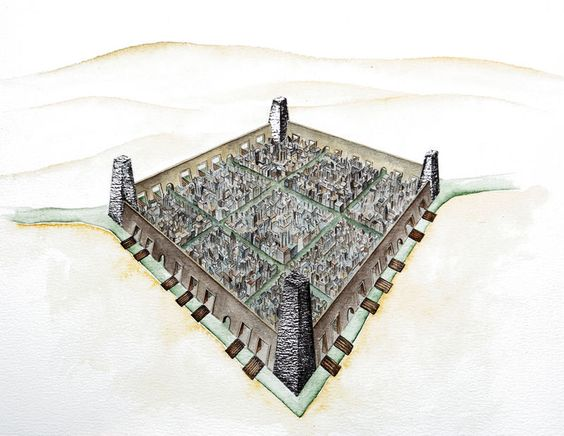

In [4]:
Image(filename='../Images/Dorothea.jpg') 

## DOROTEA

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import tables as tb
import numpy as np

In [6]:
from LogConfig import *
from PlotUtil import *
from Util import *
from PandaUtil import *

In [58]:
import FEParam as FP

In [7]:
import logging
import sys

# Get root logger (all other loggers will be derived from this logger's
# properties)
#logger = logging.getLogger()
#logger.handlers[0].stream = sys.stdout

In [8]:

logger.warning("I will output to terminal")  # No output in notebook, goes to terminal

I will output to terminal


### Nominal calibration constant (adc_per_pes)

http://localhost:8989/notebooks/SIERPE.ipynb

In [9]:
adc_to_pes = 18.07  # in the MC this is fixed for all PMTs, in data it comes from calibration

In [11]:
ls -lh '../../data/Waveforms/25ns/WF_Na_1k.h5'

-rw-r--r--  1 jjgomezcadenas  staff   508M Aug 28 20:31 ../../data/Waveforms/25ns/WF_Na_1k.h5


In [23]:
h5f = h5f =tb.open_file('../../data/Waveforms/25ns/WF_Na_1k.h5','r+')

In [24]:
 pmt_t = h5f.root.Sensors.DataPMT

In [25]:
PMT = read_data_sensors(pmt_t)

In [26]:
PMT

,active,adc_to_pes,channel,gain,x,y
0,1,20.0,0,4500000.0,23.9414,65.7785
1,1,20.0,1,4500000.0,-68.9365,-12.1554
2,1,20.0,2,4500000.0,44.9951,-53.6231
3,1,20.0,3,4500000.0,0.0000,185.0000
4,1,20.0,5,4500000.0,-118.9160,141.7180
5,1,20.0,6,4500000.0,-182.1890,32.1249
6,1,20.0,8,4500000.0,-160.2150,-92.5000
7,1,20.0,9,4500000.0,-63.2737,-173.8430
8,1,20.0,10,4500000.0,63.2737,-173.8430
9,1,20.0,12,4500000.0,160.2150,-92.5000


In [27]:
PMT['adc_to_pes'] = adc_to_pes

In [28]:
PMT

,active,adc_to_pes,channel,gain,x,y
0,1,18.07,0,4500000.0,23.9414,65.7785
1,1,18.07,1,4500000.0,-68.9365,-12.1554
2,1,18.07,2,4500000.0,44.9951,-53.6231
3,1,18.07,3,4500000.0,0.0000,185.0000
4,1,18.07,5,4500000.0,-118.9160,141.7180
5,1,18.07,6,4500000.0,-182.1890,32.1249
6,1,18.07,8,4500000.0,-160.2150,-92.5000
7,1,18.07,9,4500000.0,-63.2737,-173.8430
8,1,18.07,10,4500000.0,63.2737,-173.8430
9,1,18.07,12,4500000.0,160.2150,-92.5000


##### NB The value of adc_to_pes in changed in the temporary DF, not in file

In [29]:
pmtcwf = h5f.root.RD.pmtcwf

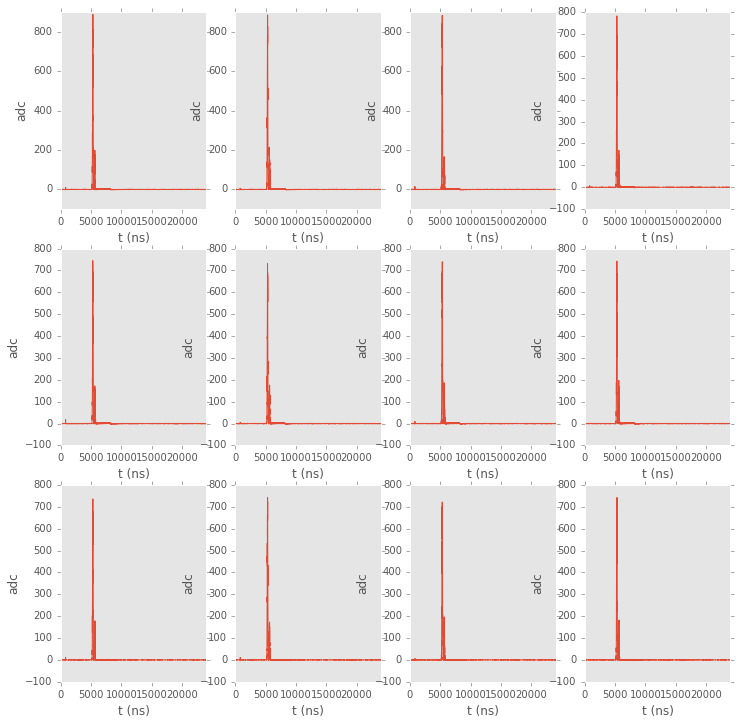

Press a key...


In [31]:
scan_waveforms(pmtcwf,list_of_events=range(1))

In [33]:
cwfdf = get_waveforms(pmtcwf,event_number=0)

In [35]:
NPMT = pmtcwf.shape[1]

In [36]:
NPMT

12

In [72]:
cwfdf

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


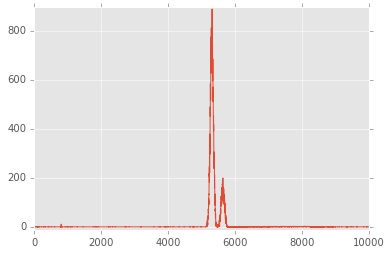

In [84]:
plts(wf0, signal_start=0, signal_end=10000, offset=10)

In [85]:
wf1 = cwfdf[1].values

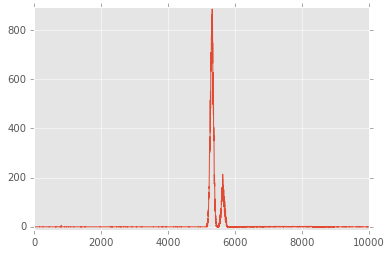

In [86]:
plts(wf1, signal_start=0, signal_end=10000, offset=10)

In [87]:
wf = wf0+wf1

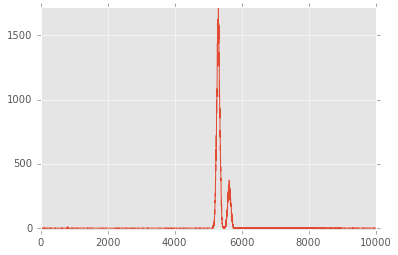

In [88]:
plts(wf, signal_start=0, signal_end=10000, offset=10)

In [89]:
PMT['adc_to_pes']

0     18.07
1     18.07
2     18.07
3     18.07
4     18.07
5     18.07
6     18.07
7     18.07
8     18.07
9     18.07
10    18.07
11    18.07
Name: adc_to_pes, dtype: float64

In [90]:
PMT['adc_to_pes'][0]

18.07

In [91]:
wf = wf0*(1./PMT['adc_to_pes'][0])+wf1*(1./PMT['adc_to_pes'][0])

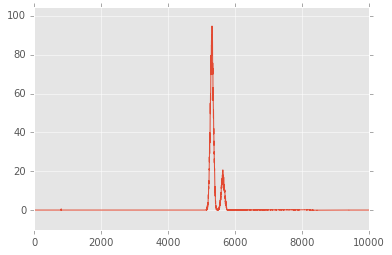

In [92]:
plts(wf, signal_start=0, signal_end=10000, offset=10)

In [183]:
def add_cwf(cwfdf,pmtDF):
    """
    input: cwfdf: each colum is the wf for one PMT.
    """
    wf =0
    for i in range(NPMT):
        adc_to_pes = pmtDF['adc_to_pes'][i]
        wf += cwfdf[i].values/adc_to_pes
    return pd.Series(wf)

In [184]:
swf = add_cwf(cwfdf,PMT)

In [185]:
type(swf)

pandas.core.series.Series

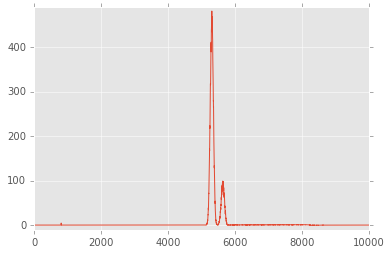

In [186]:
plts(swf.values, signal_start=0, signal_end=10000, offset=10)

In [198]:
rbwf = rebin_array(swf.values, stride=40)

In [200]:
25000/40

625

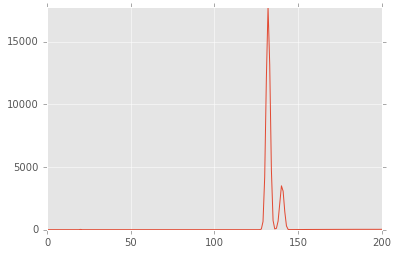

In [202]:
plts(rbwf, signal_start=0, signal_end=200, offset=10)

In [203]:
srb = pd.Series(rbwf)

In [ ]:
swf_zs = pd.DataFrame([(x,swf[x]) for x in swf.index if swf[x]>3*sqrt(NPMT)*FP.NOISE_ADC/adc_to_pes], columns=['time_bin','pes'])

In [204]:
srb_zs = pd.DataFrame([(x,srb[x]) for x in srb.index if srb[x]>3*sqrt(NPMT)*FP.NOISE_ADC/adc_to_pes], columns=['time_bin','pes'])

In [115]:
swf_zs 

,time_bin,pes
0,801,2.550059
1,802,4.550125
2,803,4.059001
3,804,3.123531
4,805,1.853838
5,806,1.689486
6,807,1.463175
7,5140,1.277325
8,5143,1.224150
9,5144,1.391360


In [205]:
srb_zs

,time_bin,pes
0,20,20.995488
1,128,50.131662
2,129,649.014002
3,130,4193.941561
4,131,12055.374180
5,132,17772.480776
6,133,13150.816037
7,134,4767.499309
8,135,733.955573
9,136,61.279348


In [191]:
def find_S12(swf,stride=4):
    T = swf['time_bin'].values
    P = swf['pes'].values
    S12 = {}
    pulse_on = 0
    j=0
    for i in range(len(T) -stride):
        logger.debug('i ={}, j={}, pulse_on = {}, T[i] ={},  T[i+1] ={}, range(T[i],T[i]+stride) ={}'.format(i,j,
                                                                                pulse_on,
                                                                                T[i],
                                                                                T[i+1],
                                                                                range(T[i],T[i]+stride)))
        if T[i+1] in range(T[i],T[i]+stride) and pulse_on == 0: #new S12
            S12[j] = []
            S12[j].append([T[i],P[i]])
            pulse_on = 1
        elif T[i+1] in range(T[i],T[i]+stride) and pulse_on == 1:
            S12[j].append([T[i],P[i]])
        elif T[i+1] not in range(T[i],T[i]+stride) and pulse_on == 1:
            pulse_on = 0
            j+=1
    
    S12L=[]
    for i in S12.keys():
        S12L.append(pd.DataFrame(S12[i]))
    return S12L
            
        

In [165]:
s12l = find_S12(swf_zs,stride=10)

In [169]:
len(s12l)

3

In [171]:
s1 = s12l[0]

In [177]:
s2_1 = s12l[1]

In [178]:
s2_2 = s12l[2]

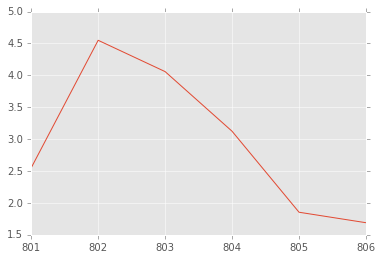

In [174]:
plt.plot(s1[0], s1[1])

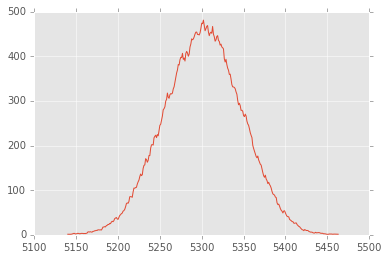

In [179]:
plt.plot(s2_1[0], s2_1[1])

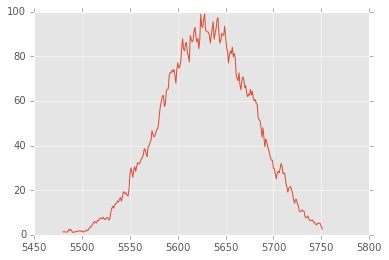

In [180]:
plt.plot(s2_2[0], s2_2[1])

### Adding waveforms and finding S1 and S2

In [192]:
def S12(pmtcwf,pmtDF,list_of_events=[0]):
    """
    Takes the earray pmtea and a list of events and scan the waveforms
    """
    
    S12 =[]
    for event in list_of_events:
        cwfdf = get_waveforms(pmtcwf,event_number=event)
        swf = add_cwf(cwfdf,pmtDF)
        swf_zs = pd.DataFrame([(x,swf[x]) for x in swf.index if swf[x]>3*sqrt(NPMT)*FP.NOISE_ADC/adc_to_pes], 
                              columns=['time_bin','pes'])
        s12l = find_S12(swf_zs,stride=10)
        S12.append(s12l)
    return S12
        
        

In [193]:
S12 = S12(pmtcwf,PMT,list_of_events=range(5))

In [195]:
S12[0]

[     0         1
 0  801  2.550059
 1  802  4.550125
 2  803  4.059001
 3  804  3.123531
 4  805  1.853838
 5  806  1.689486,         0         1
 0    5140  1.277325
 1    5143  1.224150
 2    5144  1.391360
 3    5145  1.669755
 4    5146  2.504164
 5    5147  3.115325
 6    5148  3.176095
 7    5149  2.017371
 8    5150  2.129058
 9    5151  2.848483
 10   5152  3.351094
 11   5153  3.024291
 12   5154  2.364219
 13   5155  2.467975
 14   5156  3.187999
 15   5157  3.248861
 16   5158  3.088078
 17   5159  2.649833
 18   5160  2.914481
 19   5161  2.697681
 20   5162  3.253767
 21   5163  3.810568
 22   5164  6.399212
 23   5165  6.573942
 24   5166  6.252554
 25   5167  6.928413
 26   5168  6.163140
 27   5169  5.951735
 28   5170  7.680309
 29   5171  7.748743
 ..    ...       ...
 291  5433  4.506546
 292  5434  4.000577
 293  5435  4.048299
 294  5436  5.648490
 295  5437  4.424414
 296  5438  4.528888
 297  5439  4.467421
 298  5440  4.960386
 299  5441  4.511982
 300  5442  3

### Rebinning waveforms

In [196]:
def rebin_array(a, stride):
    """
    rebins the array according to stride 
    """
    lenb = len(a)/int(stride)
    b = np.zeros(lenb)
    j=0
    for i in range(lenb):
        b[i] = np.sum(a[j:j+stride])
        j+= stride
    return b

#### Access the Nh5 DST (generated by DOROTEA)

In [51]:
class NDM:
    import tables as tb
    """
    Represents the hdf5-based NEXT Data MODEL
    
    """   
    def __init__(self, path_to_file, access_mode='r'):
        """
        path_to_file is a full path to a hdf5 DST file
        the default access mode is r+ (read mode even if file not closed)
        
        
        """
        
        self.h5f =tb.open_file(path_to_file, access_mode) 
        
        self.geom_t = self.h5f.root.Detector.DetectorGeometry
        self.pmt_t = self.h5f.root.Sensors.DataPMT
        self.sipm_t = self.h5f.root.Sensors.DataSiPM
        self.mctrk_t = self.h5f.root.MC.MCTracks
        self.fee_t = self.h5f.root.MC.FEE
        
        self.epmt = self.h5f.root.RD.epmt
        self.esipm = self.h5f.root.RD.esipm
        self.pmtrd = self.h5f.root.pmtrd
        self.sipmrd = self.h5f.root.sipmrd
        self.pmtrwf = self.h5f.root.RD.pmtrwf
        self.sipmrwf = self.h5f.root.RD.sipmrwf
    
    def __del__(self):
        self.h5f.close()
        
    def Geometry(self):
        """
        returns a PD series for the geometry data
        """
        ga = self.geom_t.read()
        G = pd.Series([ga[0][0][0],ga[0][0][1],ga[0][1][0],ga[0][1][1],
                    ga[0][2][0],ga[0][2][1],ga[0][3]],
                    index=['xdet_min','xdet_max','ydet_min','ydet_max',
                            'zdet_min','zdet_max','R'])
        return G
    
    def FEE(self):
        """
        Reads the FEE table en returns a PD Series for the simulation parameters 
        and a PD series for the values of the capacitors used in the simulation
        """
        
        fa = self.fee_t.read()
        F = pd.Series([fa[0][0],fa[0][1],fa[0][2],fa[0][3],fa[0][5],fa[0][6],fa[0][7],fa[0][8],fa[0][9],fa[0][10],
                   fa[0][11],fa[0][12]],
                    index=['offset','pmt_gain','V_gain','R',"time_step",
                           "time_daq",
                            "freq_LPF",
                            "freq_HPF",
                            "LSB",
                            "volts_to_adc",
                            "noise_fee_rms",
                            "noise_adc"])
        C =pd.Series([fa[0][4]],index=['C12'])
        return F,C
    
    def get_column_(self,pmta,ic):
        """
        access column ic of table pmta and returns column as an array
        """
        col =[]
        for i in range(pmta.shape[0]):
            col.append(pmta[i][ic])
        return np.array(col)
 
    def Sensors(self,sensor='pmt'):
        """
        reads the sensors table and returns a data frame
        sensor can take the values 'pmt' or 'sipm'
        """
        pmta = eval('self.'+sensor+'_t').read()
        PMT={}
        PMT['channel'] = self.get_column_(pmta,0)
        PMT['active'] = self.get_column_(pmta,1)
        PMT['x'] = self.get_column_(pmta,2).T[0]
        PMT['y'] = self.get_column_(pmta,2).T[1]
        PMT['gain'] = self.get_column_(pmta,3)
        PMT['adc_to_pes'] = self.get_column_(pmta,4)
        
        return pd.DataFrame(PMT)
    
    def SensorsTrueEnergy(self,sensor='pmt'):
        """
        reads the sensors energy and returns a data frame:
        sensor can take the values, pmt or sipm
        """        
        return pd.DataFrame(eval('self.e'+sensor).read())
    
    def get_waveforms_(self,pmtea,event_number):
        """
        Takes the earray pmtea and returns a DF for event_number
        """
    
        PMTWF ={}
        NPMT = pmtea.shape[1]
    
        for j in range(NPMT):
            PMTWF[j] = pmtea[event_number, j] #waveform for event event_number, PMT j
       
        return pd.DataFrame(PMTWF)
    
    def GetMCRD(self,event_number=0):
        return self.get_waveforms_(self.pmtrd,event_number) 
    
    def GetMCRD_ZS(self,event_number=0):
        """
        Zero Suprressed WF
        """
        PMTWF ={}
        NPMT = pmtea.shape[1]
    
        for j in range(NPMT):
            PMTWF[j] = pmtea[event_number, j] #waveform for event event_number, PMT j
       
        return pd.DataFrame(PMTWF)
    
    def __str__(self): 
        return "{}".format(self.h5f.__str__)
        
    
    def __repr__(self): 
        return "{}".format(self.h5f.__repr__)
        
        

In [57]:
h5f =tables.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/Prod0/WF_Na_0.h5', "r+") 

In [58]:
pmtrd = h5f.root.pmtrd

In [59]:
pmtrd

/pmtrd (EArray(100, 12, 599999), zlib(1)) ''
  atom := Int32Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 1, 32768)

In [60]:
pm0 = pmtrd[0,0]

In [61]:
pm0_zs = [x for x in pm0 if x != 0]

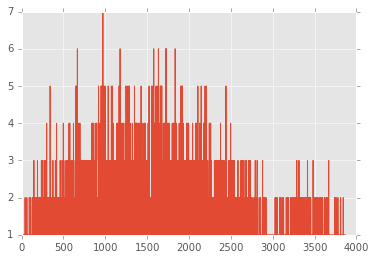

In [63]:
plt.plot(pm0_zs)

In [52]:
ndm = NDM('/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/Prod0/WF_Na_0.h5',access_mode='r+')

In [53]:
mcrdDF = ndm.GetMCRD(event_number=0)

In [56]:
mcrdDF

,0,1,2,3,4,5,6,7,8,9,10,11
0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0
